# Predicting Stock Prices using Machine Learning

### Data Mining, Machine Learning, and Deep Learning

Natalie Schober <br>
Kitti Kresznai  <br>
Anastasiya Vitaliyivna Strohonova <br>
dev-almbo 



In [1]:
#!pip install yahoo_fin==0.8.8 --ignore-installed
#!pip install pmdarima==1.8.2 --ignore-installed
#!pip install tensorflow==2.5.0 --ignore-installed

import warnings
warnings.filterwarnings('ignore')

### Data Collection

In [2]:
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
import pandas as pd

# BAC - Bank of America Coporation - financial
# BA - Boeing Company - industrial manufactoring
# MDLZ - Mondelez International Inc. - consumer goods
# PFE - Pfizer - health care 
# GOOG -  Tech industry
ticker_list = ['BAC', 'BA', 'GOOG', 'MDLZ', 'PFE']


# get historical time series data for stocks 
historical_datas = {}

for ticker in ticker_list:
    historical_datas[ticker] = get_data(ticker)

stock_data = pd.concat(historical_datas)

# get data for american indices 
sp = get_data('^GSPC')
dow = get_data('^DJI')

# clean stock data
stock_data.reset_index(inplace = True)
stock_data = stock_data.rename(columns = {'level_1': 'Date'})
stock_data = stock_data.drop(columns = ['level_0'])
stock_data['Date']= stock_data['Date'].dt.date

# clean sp500 and dow jones
sp.reset_index(inplace = True)
dow.reset_index(inplace = True)
sp = sp.rename(columns = {'index': 'Date'})
dow = dow.rename(columns = {'index': 'Date'})
sp['Date']= sp['Date'].dt.date
dow['Date']= dow['Date'].dt.date

sp = sp.rename( columns = {'high':'S&P500'})
dow = dow.rename(columns = {'high': 'DowJones'})
sp = sp[['Date', 'S&P500']]
dow = dow[['Date', 'DowJones']]


# filter out data from before 2017
stock_data['Year']=stock_data['Date'].apply(lambda x: x.year)
sp['Year']=sp['Date'].apply(lambda x: x.year)
dow['Year']=dow['Date'].apply(lambda x: x.year)

stock_data = stock_data[stock_data['Year']>=2017]
sp = sp[sp['Year']>=2017]
dow = dow[dow['Year']>=2017]
stock_data = stock_data.drop(columns = ['Year'])
sp = sp.drop(columns = ['Year'])
dow = dow.drop(columns = ['Year'])

data = stock_data.merge(sp, how ='left', on = 'Date')
data = data.merge(dow, how = 'left', on = 'Date')

data

,Date,open,high,low,close,adjclose,volume,ticker,S&P500,DowJones
0,2017-01-03,22.600000,22.680000,22.200001,22.530001,20.636000,99298100,BAC,2263.879883,19938.529297
1,2017-01-04,22.719999,22.959999,22.600000,22.950001,21.020697,76875100,BAC,2272.820068,19956.140625
2,2017-01-05,22.820000,22.930000,22.350000,22.680000,20.773388,86826400,BAC,2271.500000,19948.599609
3,2017-01-06,22.780001,22.850000,22.559999,22.680000,20.773388,66281500,BAC,2282.100098,19999.630859
4,2017-01-09,22.510000,22.709999,22.400000,22.549999,20.654318,75901500,BAC,2275.489990,19943.779297
...,...,...,...,...,...,...,...,...,...,...
5525,2021-05-19,39.900002,39.900002,39.430000,39.830002,39.830002,20209500,PFE,4116.930176,33945.808594
5526,2021-05-20,39.730000,40.250000,39.720001,40.119999,40.119999,18621100,PFE,4172.799805,34233.398438
5527,2021-05-21,40.209999,40.599998,39.910000,39.950001,39.950001,21132100,PFE,4188.720215,34415.480469
5528,2021-05-24,40.080002,40.139999,39.779999,39.810001,39.810001,16911300,PFE,4209.520020,34472.511719


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

# read the data
data = pd.read_csv("dataset 5-22-21.csv")

# get an overview of the data 
data.head()
data.info()
data.describe()

# see if there are any NA's 
missings = pd.DataFrame(data.isna().sum())
missings

# We found no more missings.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5520 entries, 0 to 5519
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  5520 non-null   int64  
 1   Date        5520 non-null   object 
 2   open        5520 non-null   float64
 3   high        5520 non-null   float64
 4   low         5520 non-null   float64
 5   close       5520 non-null   float64
 6   adjclose    5520 non-null   float64
 7   volume      5520 non-null   int64  
 8   ticker      5520 non-null   object 
 9   S&P500      5520 non-null   float64
 10  DowJones    5520 non-null   float64
dtypes: float64(7), int64(2), object(2)
memory usage: 474.5+ KB


,0
Unnamed: 0,0
Date,0
open,0
high,0
low,0
close,0
adjclose,0
volume,0
ticker,0
S&P500,0


### Exploratory Data Analysis and Data Preprocessing (e.g. Scaling)

<AxesSubplot:xlabel='Date', ylabel='close'>

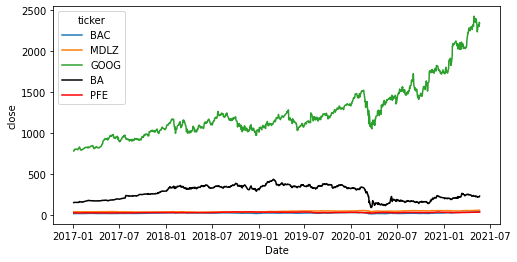

In [4]:
# Visualize the original data
stocks = data[['Date', 'open', 'high', 'low', 'close', 'ticker']]
import matplotlib.pyplot as plt

# reset the index
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks.set_index('Date')
# sort the values by Date
stocks.sort_values('Date', inplace=True)
# set the color palette for the stocks
palette ={"BAC": "C0", "MDLZ": "C1", "GOOG": "C2", "BA": "k", "PFE": "r"}
# create the figure
plt.figure(figsize=(8,4))
sns.lineplot(x = 'Date', y = 'close', data = stocks, hue = 'ticker', palette = palette)

In [5]:
# EDA to see likelyhood of stock price rising, falling, or remaining the same 
# over the course of a day within our dataset

# count the stocks that increased/decreased&/didn't change
rise = stocks.query('close > open').count()
print("Stocks that rose in price: ", rise['ticker'])

fall = stocks.query('open > close').count()
print("Stocks that fell in price: ", fall['ticker'])

steady = stocks.query('open == close').count()
print("Stocks that didn't change in price: ", steady['ticker'])

# see an average of how much stock prices rise/fall and the min and max
difference = []
difference = stocks['open'].sub(stocks['close'], axis = 0)
print("Average of stock price differences between openning and close of day: ", difference.mean())
print("Largest decrease in stock price in a day: ", min(difference))
print("Largest increase in stock price in a day: ", max(difference))


Stocks that rose in price:  2799
Stocks that fell in price:  2674
Stocks that didn't change in price:  47
Average of stock price differences between openning and close of day:  -0.1993289273718129
Largest decrease in stock price in a day:  -72.610107421875
Largest increase in stock price in a day:  76.9598388671875


In [6]:
#FEATURE SELECTION: S&P500, DowJones, volume, previous 3 days, previous 5 days, weekday (,high, low, open)

# calculate the previous 3 days (moving average)
data["mv_avg_3"]= data["close"].rolling(min_periods=1,window=3).mean().shift(1)

# calculate previous 5 days (moving average)
data["mv_avg_5"]= data["close"].rolling(min_periods=1,window=5).mean().shift(1)

#Drop the first row of the dataset as it has NANs after computing the previous x days
#IMPORTANT: ONLY RUN THE FOLLOWING STEP ONCE, SO IT DOES NOT REMOVE THE FIRST ROW EACH TIME RUNNINNG IT
data = data.iloc[1:] 

# extract weekday from Date column
data['Date'] = pd.to_datetime(data['Date'])
data['week_day'] = data.Date.apply(lambda x: x.weekday())


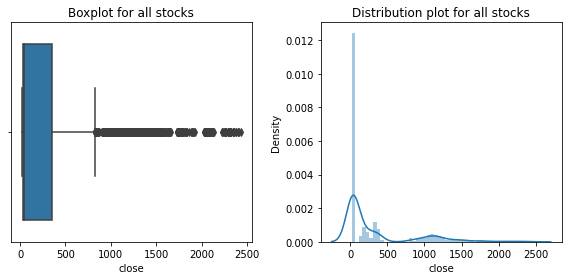

In [7]:
stocks3 = data[['Date', 'close', 'ticker']]
# reset index and sort values by Date
stocks3['Date'] = pd.to_datetime(stocks3['Date'])
stocks3.set_index('Date')
stocks3.sort_values('Date', inplace=True)

# create the figure
fig, ax = plt.subplots(1,2, figsize = (8, 4))
sns.boxplot(x= stocks3["close"], ax = ax[0])
ax[0].set_title("Boxplot for all stocks")
sns.distplot(stocks3['close'], ax = ax[1])
ax[1].set_title("Distribution plot for all stocks")
plt.tight_layout()

In [8]:
from statsmodels.tsa.stattools import adfuller
# check for stationarity

dataframes = []
tickers = ['BAC', 'BA', 'GOOG', 'MDLZ', 'PFE']
# for each ticker, test the time series, difference it and test again for stationarity
# new (differenced) data is appended to a list to replace the original column
for ticker in tickers: 
    print(ticker)
    temp = data[data['ticker']== ticker]
    # check for stationarity 
    test = adfuller(temp['close'])
    print('p-value: {}'.format(test[1]))
    # difference to make series stationary 
    temp['close'] = temp['close'].diff()
    #replace infinite values with null 
    temp.replace([np.inf, -np.inf, np.nan], 0, inplace = True)
    test2 = adfuller(temp['close'])
    print('p-value: {}'.format(test2[1]))
    dataframes.append(temp)

# concat all five data frames together
data = pd.concat(dataframes)

BAC
p-value: 0.5922909540627093
p-value: 8.639030968330125e-18
BA
p-value: 0.3790269378974299
p-value: 0.0
GOOG
p-value: 0.9960941578346153
p-value: 9.829176703739381e-11
MDLZ
p-value: 0.8906323349973715
p-value: 3.1895879651697307e-18
PFE
p-value: 0.049013573520872517
p-value: 1.7279344875653528e-10


### Scaling 

We normalize the data using sklearn's MinMaxScaler to ensure the features have a normal distribution. 



In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# sort values and reset index 
data = data.sort_values(by = 'Date')
data = data.reset_index(drop = True)

# create the X and y dataframes to scale
temp = data.drop(columns = ['Date', 'ticker', 'close'])
y = data[['close']]
temp = temp.replace(np.inf,0)
col_list = temp.columns

# instantiate the scaler, fit and transform the feature columns
ss = MinMaxScaler(feature_range=(-1,1))
ss.fit(temp)
scaled = ss.transform(temp)

# instantiate the scaler, fit and transform the target column
t_transformer = MinMaxScaler(feature_range=(-1,1))
t_transformer.fit(y)
y_trans = t_transformer.transform(y)

# replace the nan's within the scaled data with zero
nan_indices = np.where(np.isnan(scaled))
scaled[nan_indices] = 0

# create new dataframe of scaled data
scaled = pd.DataFrame(scaled, columns = col_list)
scaled['Date'] = data['Date']
scaled['ticker'] = data['ticker']
scaled['close'] = y_trans

# prepapre the data for the split
scaled['Date'] = pd.to_datetime(scaled['Date'])
scaled.set_index('Date')
X = scaled.drop(columns = ['close', 'high', 'low', 'adjclose','Unnamed: 0'], axis = 1)
y = scaled['close'].values.reshape(-1, 1)

#Split dataset into training set, validation and test set
# 80% training, 10% validation, and 10% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=42, shuffle = False)
# split again 
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size = 0.5, train_size = 0.5, random_state = 42, shuffle = False)


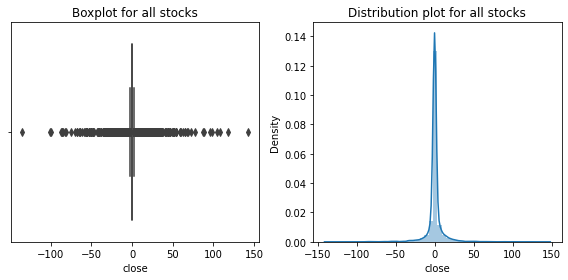

In [10]:
stocks4 = data[['Date', 'close', 'ticker']]
# prepare the data for visualization. 
stocks4['Date'] = pd.to_datetime(stocks4['Date'])
stocks4.set_index('Date')
stocks4.sort_values('Date', inplace=True)

# create the distribution and box plot for the scaled data 
fig, ax = plt.subplots(1,2, figsize = (8, 4))
sns.boxplot(x= stocks4["close"], ax = ax[0])
ax[0].set_title("Boxplot for all stocks")
sns.distplot(stocks4['close'], ax = ax[1])
ax[1].set_title("Distribution plot for all stocks")
plt.tight_layout()

<AxesSubplot:xlabel='Date', ylabel='close'>

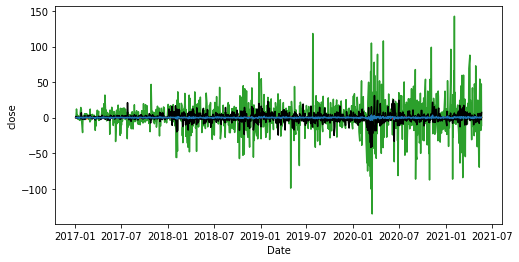

In [11]:
stocks5 = data[['Date', 'open', 'high', 'low', 'close', 'ticker']]
import matplotlib.pyplot as plt
# prepare the data for visualization
stocks5['Date'] = pd.to_datetime(stocks5['Date'])
stocks5.set_index('Date')
stocks5.sort_values('Date', inplace=True)
palette ={"BAC": "C0", "MDLZ": "C1", "GOOG": "C2", "BA": "k", "PFE": "r"}
# create the figure
plt.figure(figsize=(8,4))
sns.lineplot(x = 'Date', y = 'close', data = stocks5, hue = 'ticker', palette = palette, legend=False)

### Principal Component Analysis

Kernel PCA is an unsupervised learning algorithm and allows dimensionality reduction through non-linear projections.

In [12]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error

# adjust the training data for the Kernel PCA
X_train_adj = X_train.drop(columns = ['Date', 'ticker'])
X_valid_adj = X_valid.drop(columns = ['Date', 'ticker'])
X_test_adj = X_test.drop(columns = ['Date', 'ticker'])

# create the parameter grid that is to be searched
param_grid = [{
        "gamma": [0.001, 0.01, 1, 10],
        "kernel": ["rbf", "sigmoid", "linear", "poly"]
    }]

# instantiate the PCA
pca=KernelPCA(fit_inverse_transform=True, n_jobs=-1) 

# define scoring methid
def my_scorer(estimator, X, y=None):
    X_reduced = estimator.transform(X)
    X_preimage = estimator.inverse_transform(X_reduced)
    return -1 * mean_squared_error(X, X_preimage)

# instantiate the Gridsearch object and fit the training data
grid_search = GridSearchCV(pca, param_grid, cv=3, scoring=my_scorer)
grid_search.fit(X_train_adj)

print("Parameters selected by grid search: ", grid_search.best_params_)

# Apply the best model selected through grid search
# extract the model from the grid search object
pca_model = grid_search.best_estimator_

# transform the feature data 
X_train_pca = pca_model.transform(X_train_adj)
X_valid_pca = pca_model.transform(X_valid_adj)
X_test_pca = pca_model.transform(X_test_adj)

# create new dataframes of the kernel pca data
data_train_pca = pd.DataFrame(X_train_pca)
data_valid_pca = pd.DataFrame(X_valid_pca)
data_test_pca = pd.DataFrame(X_test_pca)

# add the date column, tickers and target values to it
data_train_pca['close'] = y_train
data_train_pca['Date'] = X_train['Date']
data_train_pca['ticker'] = X_train['ticker']

data_valid_pca['close'] = y_valid
X_valid = X_valid.reset_index(drop = True)
data_valid_pca['Date'] = X_valid['Date']
data_valid_pca['ticker'] = X_valid['ticker']

data_test_pca['close'] = y_test
X_test = X_test.reset_index(drop = True)
data_test_pca['Date'] = X_test['Date']
data_test_pca['ticker'] = X_test['ticker']


Parameters selected by grid search:  {'gamma': 1, 'kernel': 'poly'}


### Decision Tree and Random Forest

We implemented a Random Forest Regressor and a Decision Tree to understand which features are the most important when predicting stock prices.

R2 of X train & y train:  0.9796459681691083
R2 of X validate & y validate:  -0.37337293812757477
Adjusted model: R2 of X validate & y validate:  -0.27679681382102905
Adjusted model: R2 of X test & y test:  -0.2776573527134216


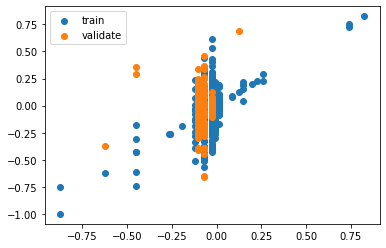

volume , Score: 0.48751
open , Score: 0.20617
mv_avg_3 , Score: 0.18670
DowJones , Score: 0.05355
mv_avg_5 , Score: 0.04118
Date , Score: 0.01641
week_day , Score: 0.00847
ticker_PFE , Score: 0.00000
ticker_MDLZ , Score: 0.00000
ticker_GOOG , Score: 0.00000
ticker_BAC , Score: 0.00000
ticker_BA , Score: 0.00000
S&P500 , Score: 0.00000


In [13]:
# Decision Tree for Important Features

from sklearn.tree import DecisionTreeRegressor
from matplotlib import pyplot

# Using scaled but not PCA data
X_train['Date'] = pd.to_datetime(X_train['Date'],infer_datetime_format=True)
X_train['Date']= X_train['Date'].apply(lambda x: x.toordinal())
X_valid['Date'] = pd.to_datetime(X_valid['Date'],infer_datetime_format=True)
X_valid['Date']= X_valid['Date'].apply(lambda x: x.toordinal())
X_test['Date'] = pd.to_datetime(X_test['Date'],infer_datetime_format=True)
X_test['Date']= X_test['Date'].apply(lambda x: x.toordinal())

# Dummy Variables / One hot encoding (split tickers into 5 columns)
X_train_DT = pd.get_dummies(X_train,columns=["ticker"],drop_first=False)
X_valid_DT = pd.get_dummies(X_valid,columns=["ticker"],drop_first=False)
X_test_DT = pd.get_dummies(X_test,columns=["ticker"],drop_first=False)

# Establish model and fit to training set
D_tree = DecisionTreeRegressor(max_depth=30, random_state=42)
D_tree.fit(X_train_DT, y_train)

# Get R2 of model on training set versus on validation set
print("R2 of X train & y train: ", D_tree.score(X_train_DT, y_train))
print("R2 of X validate & y validate: ", D_tree.score(X_valid_DT, y_valid))
# r2 of 1 is good, 0 is useless, and negative is horrible

# Use R2 for validation set as reference to try to improve performance of model
D_tree_adj = DecisionTreeRegressor(max_depth=5, random_state=42)
D_tree_adj.fit(X_train_DT, y_train)
print("Adjusted model: R2 of X validate & y validate: ", D_tree_adj.score(X_valid_DT, y_valid))
print("Adjusted model: R2 of X test & y test: ", D_tree_adj.score(X_test_DT, y_test))

# Plot training versus validation set
train_predictions_DT = D_tree_adj.predict(X_train_DT)
test_predictions_DT = D_tree_adj.predict(X_valid_DT)
plt.scatter(train_predictions_DT, y_train, label='train')
plt.scatter(test_predictions_DT, y_valid, label='validate')
plt.legend()
plt.show()

# Review feature importance scores by iterating through 
importance_DT = D_tree_adj.feature_importances_

for score, name in sorted(zip(importance_DT, list(X_train_DT.columns)),reverse=True)[:54]:
    print (name, ", Score: {:.5f}".format(score))

R2 of X train & y train:  0.8349457359523627
R2 of X validate & y validate:  -0.3126668008264166
Adjusted model: R2 of X validate & y validate:  -0.20177466459806115
Adjusted model: R2 of X test & y test:  -0.19570074505698032


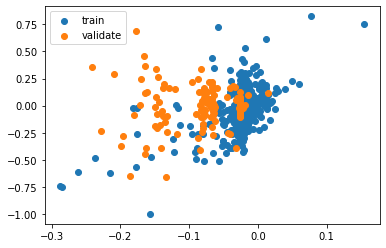

volume , Score: 0.27733
mv_avg_5 , Score: 0.26351
mv_avg_3 , Score: 0.17402
open , Score: 0.13359
Date , Score: 0.09250
DowJones , Score: 0.02719
week_day , Score: 0.01321
S&P500 , Score: 0.01283
ticker_GOOG , Score: 0.00364
ticker_MDLZ , Score: 0.00218
ticker_PFE , Score: 0.00000
ticker_BAC , Score: 0.00000
ticker_BA , Score: 0.00000


In [14]:
# Random Forest for Important Features

from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# Establish model and fit to training set
RF_tree = RandomForestRegressor(max_depth=30, random_state=42)
RF_tree.fit(X_train_DT, y_train)

# Get R2 of model on training set versus on validation set
print("R2 of X train & y train: ", RF_tree.score(X_train_DT, y_train))
print("R2 of X validate & y validate: ", RF_tree.score(X_valid_DT, y_valid))
# r2 of 1 is good, 0 is useless, and negative is horrible

# Use R2 for validation set as reference to try to improve performance of model
RF_tree_adj = RandomForestRegressor(max_depth=3, random_state=42)
RF_tree_adj.fit(X_train_DT, y_train)
print("Adjusted model: R2 of X validate & y validate: ", RF_tree_adj.score(X_valid_DT, y_valid))
print("Adjusted model: R2 of X test & y test: ", RF_tree_adj.score(X_test_DT, y_test))

# Plot training versus validation set
train_predictions_RF = RF_tree_adj.predict(X_train_DT)
test_predictions_RF = RF_tree_adj.predict(X_valid_DT)
plt.scatter(train_predictions_RF, y_train, label='train')
plt.scatter(test_predictions_RF, y_valid, label='validate')
plt.legend()
plt.show()

# Review feature importance scores by iterating through 
importance_RF = RF_tree_adj.feature_importances_

for score, name in sorted(zip(importance_RF, list(X_train_DT.columns)),reverse=True)[:54]:
    print (name, ", Score: {:.5f}".format(score))

### ARIMA Model

We implement an ARIMA model to see whether the stock price can be predicted just by its previous values using a traditional forecasting method. 


In [15]:
# import the relevant packages
import math
import numpy as np
from pmdarima.arima import auto_arima
from pmdarima import model_selection
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time

start_time = time.time()

# concat the data together again to be able to split each time series 
data_pca = pd.concat([data_train_pca, data_valid_pca, data_test_pca])
tickers = ['BAC', 'BA', 'GOOG', 'MDLZ', 'PFE']
# iterature through the ticker list to calculate an ARIMA model for each stock series 
for ticker in tickers: 
    print(ticker)
    # filter the data to get all stock values 
    temp = data_pca[data_pca['ticker']== ticker]
    # train/test split 
    train, test = model_selection.train_test_split(temp['close'], train_size = 0.8)
    # fit the model 
    model = auto_arima(train)
    # specify forecast periods 
    forecast_periods = [test.shape[0], 5]
    # calculate the forecasts for long-term and short-term prediction horizon 
    for period in forecast_periods: 
        if period == 5: 
            print("Short-Term Forecasts: ")
        else: 
            print("Long-Term Forecasts: ")
        # predict
        print("Number of forecast periods: " + str(period))
        preds = model.predict(n_periods = period, return_conf_int = False)
        # calculate and print the RMSE and MAE 
        if period == 5: 
            mae = mean_absolute_error(test.iloc[:5,], preds)
            rmse = np.sqrt(mean_squared_error(test.iloc[:5,],preds))
        else:
            mae = mean_absolute_error(test, preds)
            rmse = np.sqrt(mean_squared_error(test,preds))
        print('Test MAE: %.3f' % mae)
        print('Test RMSE: %.3f' % rmse)
print("--- %s seconds ---" % (time.time() - start_time))

BAC
Long-Term Forecasts: 
Number of forecast periods: 221
Test MAE: 0.003
Test RMSE: 0.004
Short-Term Forecasts: 
Number of forecast periods: 5
Test MAE: 0.003
Test RMSE: 0.004
BA
Long-Term Forecasts: 
Number of forecast periods: 221
Test MAE: 0.030
Test RMSE: 0.040
Short-Term Forecasts: 
Number of forecast periods: 5
Test MAE: 0.027
Test RMSE: 0.030
GOOG
Long-Term Forecasts: 
Number of forecast periods: 221
Test MAE: 0.171
Test RMSE: 0.235
Short-Term Forecasts: 
Number of forecast periods: 5
Test MAE: 0.168
Test RMSE: 0.199
MDLZ
Long-Term Forecasts: 
Number of forecast periods: 221
Test MAE: 0.003
Test RMSE: 0.004
Short-Term Forecasts: 
Number of forecast periods: 5
Test MAE: 0.006
Test RMSE: 0.006
PFE
Long-Term Forecasts: 
Number of forecast periods: 221
Test MAE: 0.003
Test RMSE: 0.004
Short-Term Forecasts: 
Number of forecast periods: 5
Test MAE: 0.003
Test RMSE: 0.005
--- 100.04920387268066 seconds ---


### Logistic Regression

The Logistic Regression classifes the data according to the target variable "Price change", with "Price change" being either an increase or decrease. 

CPU times: user 38.1 s, sys: 24.9 s, total: 1min 3s
Wall time: 42 s


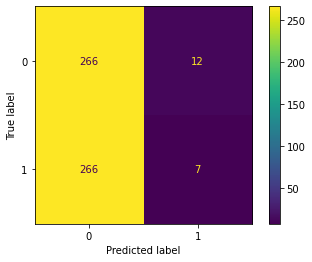

              precision    recall  f1-score   support

           0       0.50      0.96      0.66       278
           1       0.37      0.03      0.05       273

    accuracy                           0.50       551
   macro avg       0.43      0.49      0.35       551
weighted avg       0.43      0.50      0.36       551

Precision: [0.5        0.36842105]
Recall: [0.95683453 0.02564103]
F-Score: [0.65679012 0.04794521]
Support: [278 273]


In [16]:
from sklearn.linear_model import LogisticRegression

#Logistic Regression
from sklearn import preprocessing
from sklearn import utils
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# calculate the target variable for logistic regression 
# 1 is price increase, 0 is price decrease

# sort by ticker 
data_train_pca = data_train_pca.sort_values(by=['ticker', 'Date'])
data_valid_pca = data_valid_pca.sort_values(by=['ticker', 'Date'])
data_test_pca = data_test_pca.sort_values(by=['ticker', 'Date'] )

# calculate increase/decrease
data_train_pca['Price change'] = (data_train_pca['close'].diff()).apply(lambda x: "1" if x > 0 else "0").shift(-1)
data_valid_pca['Price change'] = (data_valid_pca['close'].diff()).apply(lambda x: "1" if x > 0 else "0").shift(-1)
data_test_pca['Price change'] = (data_test_pca['close'].diff()).apply(lambda x: "1" if x > 0 else "0").shift(-1)

# remove rows with nan from y and x 
data_train_pca = data_train_pca.dropna(subset = ['Price change'])
data_valid_pca = data_valid_pca.dropna(subset = ['Price change'])
data_test_pca = data_test_pca.dropna(subset = ['Price change'])

# prepare training, testing and validation data
X_train_pca = data_train_pca.drop(columns = ['Date', 'close', 'ticker','Price change'])
y_train_pca = data_train_pca['Price change']
X_valid_pca = data_valid_pca.drop(columns = ['Date', 'close', 'ticker', 'Price change'])
y_valid_pca = data_valid_pca['Price change']
X_test_pca = data_test_pca.drop(columns = ['Date', 'close', 'ticker', 'Price change'])
y_test_pca = data_test_pca['Price change']

# instantiate model 
lr_model = LogisticRegression(max_iter = 1000, random_state=42)

# Build GridSearch Pipeline
param_values = {'C': [0.001,0.01,0.1,1,10,100,1000]}

grid = GridSearchCV(lr_model, param_grid= param_values)
# fit the model with data
%time grid.fit(X_train_pca,y_train_pca)

# evaluate the performance on the test set
y_pred_valid = grid.predict(X_test_pca)

# best estimator 
grid.best_estimator_
# LogisticRegression(C=0.001, max_iter=1000, random_state=42)

# best parameters 
grid.best_params_

# plot the conclusion matric
metrics.plot_confusion_matrix(grid, X_test_pca, y_test_pca, labels = ["0", "1"])
plt.show()

# show the classification report 
clf_report = metrics.classification_report(y_test_pca, y_pred_valid, labels = ["0", "1"])
print(clf_report)

# calculate even more metrics
metrics = metrics.precision_recall_fscore_support(y_test_pca, y_pred_valid)


print("Precision: " + str(metrics[0]))
print("Recall: " +  str(metrics[1]))
print("F-Score: " + str(metrics[2]))
print("Support: " + str(metrics[3]))


### Support Vector Regression (SVR)

We use a Support Vector Regression to predict continuous stock prices with a Support Vector Machine. 

In [17]:
from sklearn.svm import SVR
from sklearn import metrics
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV

# prepare training, testing and validation data
X_train_svr = data_train_pca.drop(columns = ['Date', 'close', 'ticker', 'Price change'])
X_valid_svr = data_valid_pca.drop(columns = ['Date', 'close', 'ticker', 'Price change'])
X_test_svr = data_test_pca.drop(columns = ['Date', 'close', 'ticker', 'Price change'])
y_train_svr = data_train_pca['close']
y_valid_svr = data_valid_pca['close']
y_test_svr = data_test_pca["close"]


# Set up model
svr = SVR()

X_check_svr = pd.concat([X_train_svr, X_valid_svr], ignore_index=True)
y_check_svr = np.concatenate((y_train_svr, y_valid_svr))

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if x in X_train_svr.index else 0 for x in X_check_svr.index]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

# Use a grid search cross-validation to explore combinations of parameters

param_grid = {'kernel': ['poly', 'rbf', 'sigmoid'],
             'C': [0.001, 0.1, 1, 10, 100],
             'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
            'epsilon': [0.01, 0.1, 1]}
            
grid = RandomizedSearchCV(estimator=svr, cv=pds, param_distributions=param_grid, n_jobs = -1, random_state=42)

%time grid.fit(X_check_svr, y_check_svr)
print(grid.best_params_)

CPU times: user 1.01 s, sys: 52.1 ms, total: 1.06 s
Wall time: 7.4 s
{'kernel': 'sigmoid', 'gamma': 0.001, 'epsilon': 0.01, 'C': 1}


In [18]:
# Use cross-validated model to predict the labels for the test data, which the model has not yet seen:

svr_model = grid.best_estimator_
y_pred_svr = svr_model.predict(X_test_svr)

from sklearn.metrics import r2_score
# regression score function, best possible score is 1
print("R2 score:", r2_score(y_test_svr, y_pred_svr))

from sklearn.metrics import mean_absolute_error
# average magnitude of the errors, best possible score is 0
print("Mean absolute error:", mean_absolute_error(y_test_svr, y_pred_svr))

from sklearn.metrics import mean_squared_error
# RMSE, the distance, on average, of a data point from the fitted line, measured along a vertical line.
print("Root mean squared error:", mean_squared_error(y_test_svr, y_pred_svr, squared = False))

#The RMSE will always be larger or equal to the MAE; the greater difference between them, the greater the variance in the individual errors in the sample.

R2 score: 0.0191881098639628
Mean absolute error: 0.04528851741697144
Root mean squared error: 0.11455298771054803


In [19]:
# look at values of predictions versus true y test data
comparison = pd.DataFrame(y_test_svr)
#comparison.rename(columns = {'close':'test'}, inplace = True)
y_pred_svr = pd.DataFrame(y_pred_svr)
comparison['prediction'] = y_pred_svr
print(comparison)

under_pred = comparison.query('close > prediction').count()
print("Number of under predictions: ", under_pred['close'])

over_pred = comparison.query('prediction > close').count()
print("Number of over predictions: ", over_pred['close'])

accurate_pred = comparison.query('prediction == close').count()
print("Accurate predictions: ", accurate_pred['close'])

# see an average of how much stock prices rise/fall and the min and max
pred_diff = []
pred_diff = comparison['prediction'].sub(comparison['close'], axis = 0)
print("Average of scaled stock price differences between prediction and actual close: ", pred_diff.mean())
print("Smallest difference between scaled prediction and close: ", min(abs(pred_diff)))
print("Largest difference between scaled prediction and close: ", max(abs(pred_diff)))

        close  prediction
1   -0.055260   -0.026633
4   -0.038063   -0.024971
7   -0.019427   -0.025285
12  -0.051878   -0.024655
18  -0.059073   -0.024394
..        ...         ...
523 -0.026335   -0.016881
529 -0.025112   -0.014778
535 -0.026191   -0.013781
537 -0.027342   -0.016812
544 -0.023673   -0.016104

[551 rows x 2 columns]
Number of under predictions:  154
Number of over predictions:  397
Accurate predictions:  0
Average of scaled stock price differences between prediction and actual close:  -2.064976292493721e-05
Smallest difference between scaled prediction and close:  5.000503270499723e-06
Largest difference between scaled prediction and close:  1.0132891465361604


### Neural Network: Long-Term Short-Term Memory (LSTM)

LSTM is a type of Recurrent Neural Networks (RNN) used in the field of supervised Deep Learning and can store long-term information about the data, it is therefore better suited for long-term forecasts than ARIMA. 

In [20]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

from sklearn.metrics import mean_squared_error
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import optimizers
from sklearn import preprocessing
#from joblib import dump, load
import plotly.express as px

#define train, test and valid set
X_train_f = X_train_pca
X_test_f = X_test_pca
X_valid_f = X_valid_pca

y_train_f = data_train_pca['close']
y_test_f = data_test_pca['close']
y_valid_f = data_valid_pca['close']


#create time lags
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
# reshape to [samples, time_steps, n_features]
X_train_f, y_train_f = create_dataset(X_train_f, y_train_f, time_steps)
X_test_f, y_test_f = create_dataset(X_test_f, y_test_f, time_steps)

print("*** SHAPES")
print(X_train_f.shape, y_train_f.shape)
print(X_test_f.shape, y_test_f.shape)

# Building the model
model = keras.Sequential()
model.add(keras.Input(shape=((X_train_f.shape[1], X_test_f.shape[2])))) #input shape

model.add(layers.LSTM(300, return_sequences=False, activation = 'tanh'))
model.add(layers.BatchNormalization())

model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

*** SHAPES
(4384, 30, 116) (4384,)
(521, 30, 116) (521,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               500400    
_________________________________________________________________
batch_normalization (BatchNo (None, 300)               1200      
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 501,901
Trainable params: 501,301
Non-trainable params: 600
_________________________________________________________________


In [21]:
#fit the model
hist = model.fit(X_train_f, y_train_f, batch_size = 200, epochs = 50, shuffle=False, validation_split=0.1)


Epoch 1/50
20/20 [==============================] - 10s 414ms/step - loss: 2.0016 - val_loss: 0.0525
Epoch 2/50
20/20 [==============================] - 7s 362ms/step - loss: 2.2187 - val_loss: 0.0834
Epoch 3/50
20/20 [==============================] - 7s 362ms/step - loss: 2.1040 - val_loss: 0.0456
Epoch 4/50
20/20 [==============================] - 7s 354ms/step - loss: 1.6869 - val_loss: 0.0466
Epoch 5/50
20/20 [==============================] - 7s 353ms/step - loss: 1.0928 - val_loss: 0.0391
Epoch 6/50
20/20 [==============================] - 7s 353ms/step - loss: 0.8070 - val_loss: 0.0567
Epoch 7/50
20/20 [==============================] - 7s 357ms/step - loss: 0.6966 - val_loss: 0.0409
Epoch 8/50
20/20 [==============================] - 7s 358ms/step - loss: 0.5708 - val_loss: 0.2222
Epoch 9/50
20/20 [==============================] - 7s 357ms/step - loss: 1.1280 - val_loss: 0.1328
Epoch 10/50
20/20 [==============================] - 7s 355ms/step - loss: 1.6744 - val_loss: 0.328

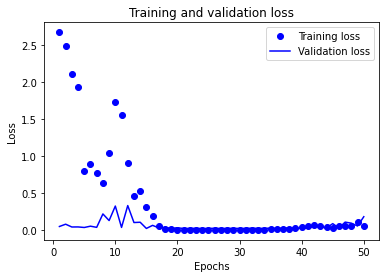

In [22]:
#plot loss of training and validation set
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
#make prediction from model
y_pred = model.predict(X_test_f)

#evaluate performance of model
y_test_f = y_test_f.reshape(-1,1)
y_test_inv = t_transformer.inverse_transform(y_test_f)
y_pred_inv = t_transformer.inverse_transform(y_pred)

results = model.evaluate(X_test_f, y_test_f)
print("mse: %s" % (mean_squared_error(y_test_inv, y_pred_inv)))
print(results)

17/17 [==============================] - 1s 32ms/step - loss: 2.3282
mse: 44969.99433302891
2.3281869888305664


In [24]:
#plot actual vs. predicted stock prices
a = np.repeat(1, len(y_test_f))
b = np.repeat(2, len(y_pred))

# prepare data for visualization 
df1 = pd.DataFrame(data = np.concatenate((y_test_inv,(np.reshape(a, (-1, 1)))),axis=1), columns=["price","type"])
df2 = pd.DataFrame(data = np.concatenate((y_pred_inv,(np.reshape(b, (-1, 1)))),axis=1), columns=["price","type"])

frames = [df1, df2]
result = pd.concat(frames, ignore_index=False)

result["type"].replace({1: "actual", 2: "predict"}, inplace=True)
(result[result.type == "actual"]).head(10)

# create figure
fig = px.line(result, x=result.index.values, y="price", color='type', title='Stock Price')
fig.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0c40d680-c720-488b-84aa-395d60b39534' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>